# Importing Libraries

In [1]:
import os
import warnings
from dotenv import load_dotenv
from langchain_groq import ChatGroq
from langchain_huggingface.embeddings import HuggingFaceEmbeddings
from langchain_community.vectorstores import Chroma

warnings.filterwarnings("ignore")

load_dotenv()

GROQ_API_KEY = os.getenv("GROQ_API_KEY")
model_name = "deepseek-r1-distill-llama-70b"
# emb_model = "togethercomputer/m2-bert-80M-32k-retrieval"
emb_model = "sentence-transformers/all-mpnet-base-v2"
embedding_function = HuggingFaceEmbeddings(model_name=emb_model)

llm = ChatGroq(
    groq_api_key=GROQ_API_KEY,
    model=model_name,
)

In [3]:
from typing import Literal, Optional

from langchain_core.messages import HumanMessage
from langgraph.graph import START, END, StateGraph, MessagesState
from langchain_core.tools import tool
from langgraph.prebuilt import ToolNode


@tool
def get_weather(location: str):
    """Call to get the current weather"""
    if location.lower() in ['bengaluru']:
        return "It is 15 deg C and cloudy"
    return "It is 32 deg C and sunny."


tools = [get_weather]

model = llm.bind_tools(tools)
model

RunnableBinding(bound=ChatGroq(client=<groq.resources.chat.completions.Completions object at 0x000002B14F318170>, async_client=<groq.resources.chat.completions.AsyncCompletions object at 0x000002B14F31B560>, model_name='deepseek-r1-distill-llama-70b', model_kwargs={}, groq_api_key=SecretStr('**********')), kwargs={'tools': [{'type': 'function', 'function': {'name': 'get_weather', 'description': 'Call to get the current weather', 'parameters': {'properties': {'location': {'type': 'string'}}, 'required': ['location'], 'type': 'object'}}}]}, config={}, config_factories=[])

In [5]:
def call_model(state: MessagesState):
    messages = state['messages']
    response = model.invoke(messages)
    return {"messages": [response]}


def should_continue(state: MessagesState) -> Literal["tools", END]:
    messages = state['messages']
    last_message = messages[-1]
    if last_message.tool_calls:
        return "tools"
    return END

# Subgraph with same State

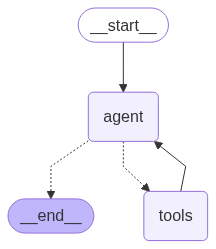

In [7]:
subgraph_workflow = StateGraph(MessagesState)
tool_node = ToolNode(tools)

subgraph_workflow.add_node("agent", call_model)
subgraph_workflow.add_node("tools", tool_node)

subgraph_workflow.add_conditional_edges("agent", should_continue)

subgraph_workflow.add_edge("tools", "agent")

subgraph_workflow.set_entry_point("agent")

subgraph = subgraph_workflow.compile()
subgraph

In [8]:
messages1 = [HumanMessage(content="How is the weather in Bengaluru")]
subgraph.invoke({"messages": messages1})

{'messages': [HumanMessage(content='How is the weather in Bengaluru', additional_kwargs={}, response_metadata={}, id='bbd471ac-fae4-400b-8f97-a65e77a66180'),
  AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'fg83y0kfy', 'function': {'arguments': '{"location":"Bengaluru"}', 'name': 'get_weather'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 170, 'prompt_tokens': 130, 'total_tokens': 300, 'completion_time': 0.643576416, 'prompt_time': 0.020633383, 'queue_time': 0.044372446, 'total_time': 0.664209799}, 'model_name': 'deepseek-r1-distill-llama-70b', 'system_fingerprint': 'fp_76307ac09b', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run--a7795095-0a7b-4394-ba35-94ab59cc8efa-0', tool_calls=[{'name': 'get_weather', 'args': {'location': 'Bengaluru'}, 'id': 'fg83y0kfy', 'type': 'tool_call'}], usage_metadata={'input_tokens': 130, 'output_tokens': 170, 'total_tokens': 300}),
  ToolMessage(content='It is 15 deg C and cloudy', name='get_we

# Main Graph with Same State

In [11]:
def start_node(state: MessagesState):
    return state

main_graph = StateGraph(MessagesState)

main_graph.add_node("start", start_node)
main_graph.add_node("subgraph", subgraph)

main_graph.add_edge(START, "start")
main_graph.add_edge("start", "subgraph")

graph = main_graph.compile()

In [12]:
initial_state = {"messages": messages1}
result = graph.invoke(initial_state, subgraphs=False)
result

{'messages': [HumanMessage(content='How is the weather in Bengaluru', additional_kwargs={}, response_metadata={}, id='bbd471ac-fae4-400b-8f97-a65e77a66180'),
  AIMessage(content='', additional_kwargs={'tool_calls': [{'id': '9tqaxjz1c', 'function': {'arguments': '{"location":"Bengaluru"}', 'name': 'get_weather'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 104, 'prompt_tokens': 130, 'total_tokens': 234, 'completion_time': 0.429848149, 'prompt_time': 0.020751233, 'queue_time': 0.050510157, 'total_time': 0.450599382}, 'model_name': 'deepseek-r1-distill-llama-70b', 'system_fingerprint': 'fp_1bbe7845ec', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run--c081dbcd-fc1f-4ade-8888-d3b99a4bca70-0', tool_calls=[{'name': 'get_weather', 'args': {'location': 'Bengaluru'}, 'id': '9tqaxjz1c', 'type': 'tool_call'}], usage_metadata={'input_tokens': 130, 'output_tokens': 104, 'total_tokens': 234}),
  ToolMessage(content='It is 15 deg C and cloudy', name='get_we

# Different State

In [13]:
from typing import TypedDict
class MessagesState(TypedDict):
    parent_messages: list[str]

def invoke_subgraph(state: MessagesState):
    subgraph_output = subgraph.invoke({"messages": state['parent_messages']})
    state['parent_messages'] = subgraph_output['messages']
    return state

main_graph = StateGraph(MessagesState)

main_graph.add_node("start", start_node)
main_graph.add_node("invoke_subgraph", invoke_subgraph)

main_graph.add_edge(START, "start")
main_graph.add_edge("start", "invoke_subgraph")


graph = main_graph.compile()

In [17]:
initial_state = {
    "parent_messages": [HumanMessage(content="What's the weather in bengaluru?")]
}
graph.invoke(initial_state, subgraphs=True)

{'parent_messages': [HumanMessage(content="What's the weather in bengaluru?", additional_kwargs={}, response_metadata={}, id='19b25a49-b1c1-4941-908a-31f15cf00a19'),
  AIMessage(content='', additional_kwargs={'tool_calls': [{'id': '6hrzgcvjy', 'function': {'arguments': '{"location":"bengaluru"}', 'name': 'get_weather'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 105, 'prompt_tokens': 133, 'total_tokens': 238, 'completion_time': 0.455422177, 'prompt_time': 0.021215723, 'queue_time': 0.050924577, 'total_time': 0.4766379}, 'model_name': 'deepseek-r1-distill-llama-70b', 'system_fingerprint': 'fp_1bbe7845ec', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run--252ab2f4-3fd1-4850-87f4-3f837ec5c1bc-0', tool_calls=[{'name': 'get_weather', 'args': {'location': 'bengaluru'}, 'id': '6hrzgcvjy', 'type': 'tool_call'}], usage_metadata={'input_tokens': 133, 'output_tokens': 105, 'total_tokens': 238}),
  ToolMessage(content='It is 15 deg C and cloudy', name='